In [1]:
__author__ = 'tkurth'
import sys
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
%matplotlib inline
import time
import re
import datetime as dt
import h5py as h5

# Useful Functions

In [2]:
# EXTRACTING
def get_times_losses(all_lines):
    dt0 = all_lines[0][0]
    all_seconds = [(line[0]-dt0).total_seconds() % 86400 for line in all_lines]
    all_losses = [line[3] for line in all_lines]
    return all_seconds, all_losses

# LOADING
def load_results(log_file_name):
    all_lines = []
    with open(log_file_name, "r") as f:
        for line in f.readlines():
            if re.match('(.*)solver\.cpp(.*)Iteration(.*)loss(.*)', line):
                try:
                    (
                     _,time_field,pid,source_line,worker_id,check_iteration,
                     niter,check_loss,check_equals,loss
                    ) =line.split()
                    assert(check_iteration=="Iteration")
                    assert(check_loss=="loss")
                    assert(check_equals=='=')
                    loss=float(loss)
                    niter=int(niter[:-1])
                    worker_id = int(worker_id[1:-1])
                    difft = dt.datetime.strptime(time_field, "%H:%M:%S.%f")
                
                    #append to dictionary
                    new_line = {"time": difft, "rank": worker_id, "iteration": niter, "loss": loss}
                
                    all_lines.append(new_line)
                except:
                    continue
    return all_lines

# Logfiles HEP

In [3]:
directory='/global/cscratch1/sd/tkurth/atlas_dl/atlas_caffe/runs_preselect_augmented'
iters_per_epoch=870
window=1

# Logfiles Fish

In [ ]:
directory='/global/cscratch1/sd/tkurth/fish_detection/models/VGGNet/SSD_300x300/run'
iters_per_epoch=94
window=1

# Read Logfiles

In [4]:
output='training.out'

logdf=pd.DataFrame(load_results(directory+'/'+output))

#only keep latest element
logdf=pd.DataFrame(logdf.groupby(["iteration","rank"]).apply(lambda x: x[['time','loss']].iloc[-1]))
logdf.reset_index(inplace=True)
#logdf.rename(columns={0:''})

#sort values
logdf.sort_values(by=["iteration","rank","time"],ascending=True,inplace=True)

# Plot learning curve

In [5]:
#average over nodes:
plotdf=logdf.copy()
plotdf=plotdf[["iteration","loss"]].groupby(["iteration"]).mean().reset_index()
plotdf['loss']=pd.rolling_mean(plotdf["loss"],window=window)
plotdf['iteration']/=np.float(iters_per_epoch)

/global/common/cori/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1,center=False).mean()


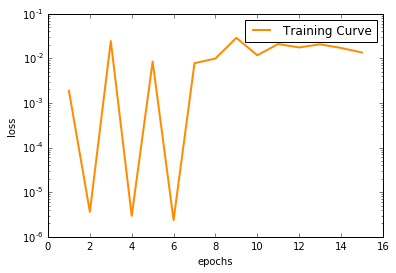

In [6]:
#plot the data
plt.figure()
lw = 2
#full curve
plt.plot(plotdf.iteration, plotdf.loss, color='darkorange', lw=lw, label='Training Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend(loc="upper right")
plt.savefig('plots/learning_curve.png',dpi=300)